# CLTV Prediction with BG-NBD and Gamma-Gamma

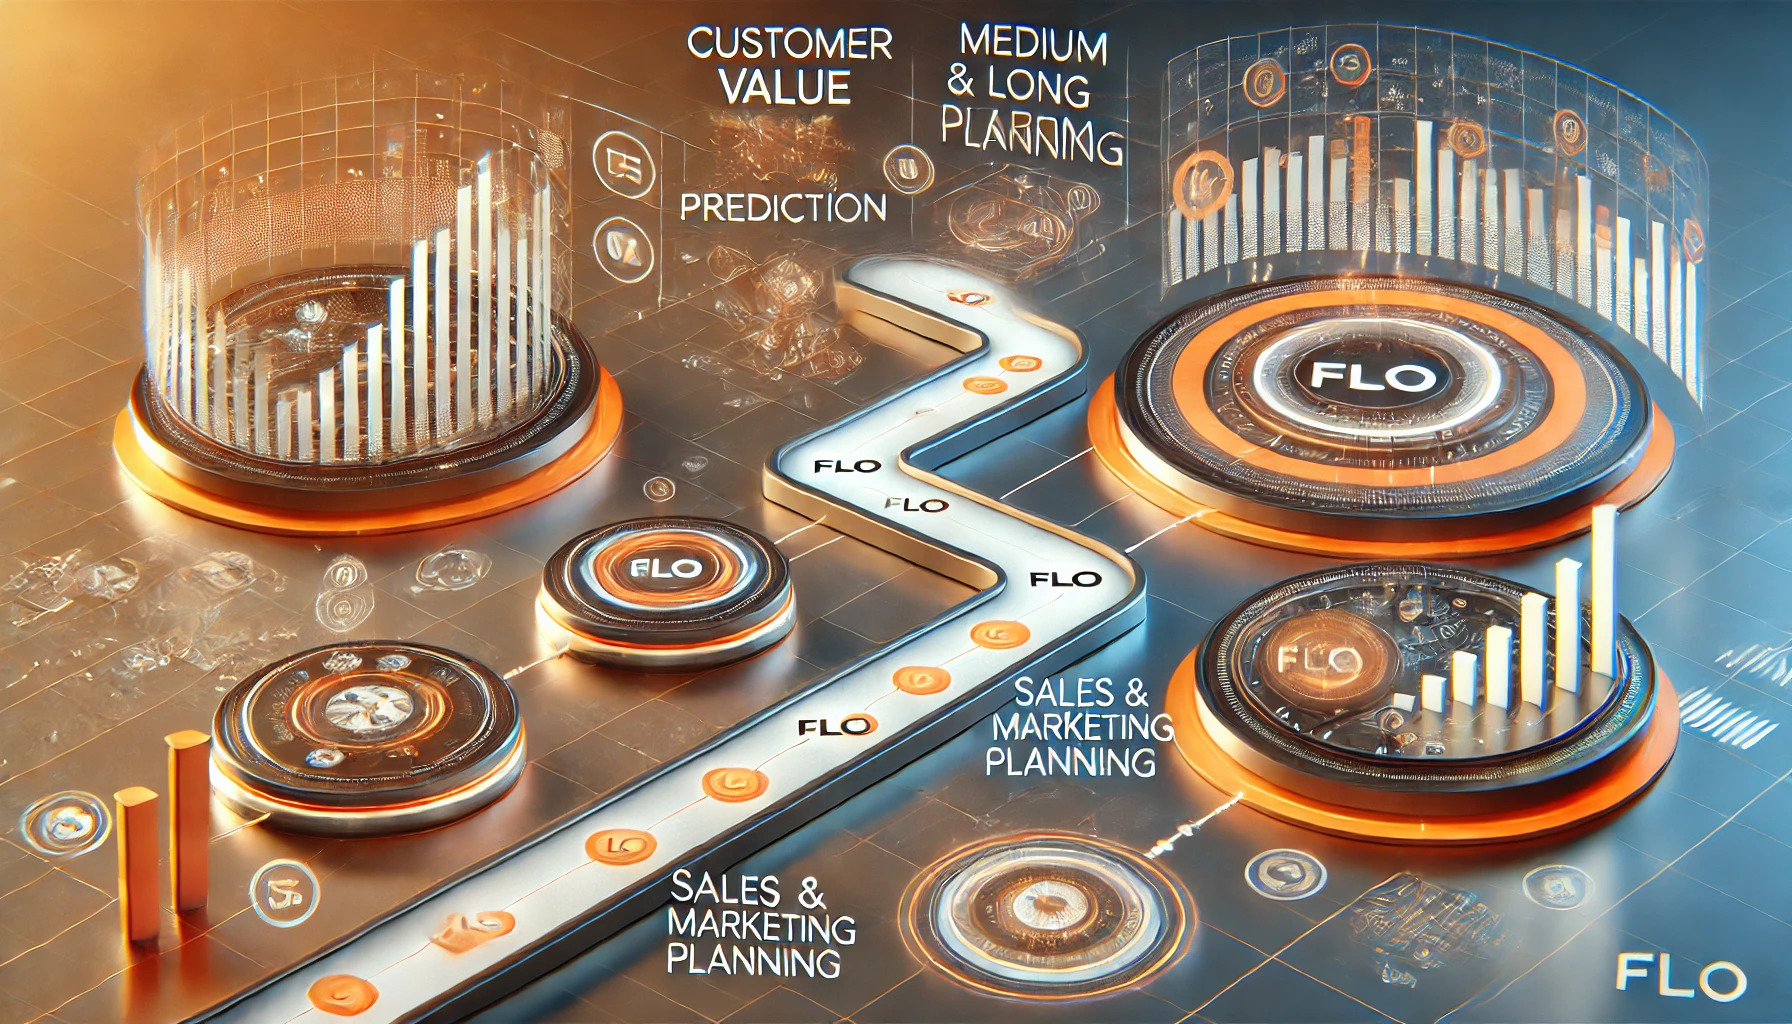

# Business Problem

FLO wants to set a roadmap for its sales and marketing activities. To make medium and long-term plans, the company needs to estimate the potential value that existing customers will bring in the future.

# Dataset Story

The dataset consists of past shopping behavior of customers who shopped at FLO as OmniChannel (both online and offline) between 2020 and 2021.

# Variables

master_id: Unique customer number

order_channel: The platform used for shopping (Android, iOS, Desktop, Mobile, Offline)

last_order_channel: The channel used for the last purchase

first_order_date: The date of the customer's first purchase

last_order_date: The date of the customer's last purchase

last_order_date_online: The date of the customer's last online purchase

last_order_date_offline: The date of the customer's last offline purchase

order_num_total_ever_online: Total number of purchases made on the online platform

order_num_total_ever_offline: Total number of purchases made on the offline platform

customer_value_total_ever_offline: Total amount spent in offline purchases

customer_value_total_ever_online: Total amount spent in online purchases

interested_in_categories_12: List of categories the customer shopped in the last 12 months

# Task 1: Data Preparation

**Step 1: Read the dataset flo_data_20K.csv.**

In [1]:
pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 18.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from pandas import read_excel, read_csv

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from sklearn.preprocessing import MinMaxScaler

In [4]:
df_ = pd.read_csv ("/kaggle/input/cltv-prediction-with-bg-nbd-and-gamma-gamma/flo_data_20k.csv")

In [5]:
df = df_.copy()

In [6]:
df.columns

Index(['master_id', 'order_channel', 'last_order_channel', 'first_order_date', 'last_order_date', 'last_order_date_online', 'last_order_date_offline', 'order_num_total_ever_online', 'order_num_total_ever_offline', 'customer_value_total_ever_offline', 'customer_value_total_ever_online', 'interested_in_categories_12'], dtype='object')

In [7]:
def check_df(dataframe, head=5):
    print("---------------------------- SHAPE ---------------------------")
    print(dataframe.shape)

    print("---------------------------- TYPES ---------------------------")
    print(dataframe.dtypes)

    print("---------------------------- HEAD ----------------------------")
    print(dataframe.head(head))

    print("---------------------------- TAIL ----------------------------")
    print(dataframe.tail(head))

    print("---------------------------- NA ------------------------------")
    print(dataframe.isnull().sum())

    print("---------------------------- QUANTILES -----------------------")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


check_df(df)

---------------------------- SHAPE ---------------------------
(19945, 12)
---------------------------- TYPES ---------------------------
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
---------------------------- HEAD ----------------------------
                              master_id order_channel last_order_channel first_order_date last_order_date last_order_date_online last_order_date_offline  order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offlin

**Step 2, you need to define the necessary outlier_thresholds and replace_with_thresholds functions to handle outliers. Note that when calculating CLTV, the frequency values must be integers. Therefore, the lower and upper limits should be rounded using round().**

In [8]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [9]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

**Step 3, you need to handle outliers in the variables "order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", and "customer_value_total_ever_online". The outliers should be identified and replaced.**

In [10]:
replace_with_thresholds(df, "order_num_total_ever_online")
replace_with_thresholds(df, "order_num_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_online")

**Step 4, omnichannel customers refer to customers who have made purchases both online and offline. You need to create new variables for the total number of purchases and the total spending for each customer.**

In [11]:
df["TotalValue"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["TotalPrice"] = df["customer_value_total_ever_online"] + df["customer_value_total_ever_offline"]

**Step 5, you need to check the data types of the variables. For the variables that contain dates, you should convert their type to date.**

In [12]:
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

# Task 2: Creating the CLTV Data Structure

**Step 1: Set the analysis date as 2 days after the date of the last purchase in the dataset.**

In [13]:
df["last_order_date"].max() # Timestamp('2021-05-30)
today_date = dt.datetime(2021,6,1)

**Step 2: Create a new CLTV DataFrame that includes the customer_id, recency_cltv_weekly, T_weekly, frequency, and monetary_cltv_avg values. The Monetary value should be the average value per purchase, and the recency and tenure values should be considered on a weekly basis.**

recency_cltv_weekly: Time elapsed since the last purchase, on a weekly basis (specific to the user).

T_weekly: The customer's age in weeks (how long it has been since the first purchase relative to the analysis date).

frequency: The total number of repeat purchases (where frequency > 1).

monetary_cltv_avg: The average earnings per purchase.

In [14]:
CLTV = pd.DataFrame()
CLTV["customer_id"] = df["master_id"]
CLTV["recency_cltv_weekly"] = (df["last_order_date"] - df["first_order_date"]).dt.days / 7
CLTV["T_weekly"] = (today_date - df["first_order_date"]).dt.days / 7
CLTV["frequency"] = df["TotalValue"]
CLTV['frequency'] = CLTV['frequency'].astype(int)
CLTV= CLTV[(CLTV['frequency'] > 1)]
CLTV["monetary"] = df["TotalPrice"]
CLTV["monetary_cltv_avg"] = CLTV["monetary"] / CLTV["frequency"]

In [15]:
CLTV.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5,939.370,187.874
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,21,2013.550,95.883
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5,585.320,117.064
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2,121.970,60.985
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2,209.980,104.990


# Task 3: Setting Up the BG/NBD and Gamma-Gamma Models and Calculating CLTV

**Step 1: Fit the BG/NBD model.**

In [16]:
bgf = BetaGeoFitter(penalizer_coef=0.001)


bgf.fit(CLTV["frequency"],
       CLTV["recency_cltv_weekly"],
        CLTV["T_weekly"])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

**Predict the expected purchases from customers in the next 3 months and add it as exp_sales_3_month to the CLTV dataframe.**

In [17]:
bgf.predict(4 * 3,
            CLTV['frequency'],
         CLTV['recency_cltv_weekly'],
            CLTV['T_weekly'])


CLTV["expected_purc_3_month"] = bgf.predict(4 * 3,
                                               CLTV['frequency'],
                                              CLTV['recency_cltv_weekly'],
                                             CLTV['T_weekly'])

**Predict the expected purchases from customers in the next 6 months and add it as exp_sales_6_month to the CLTV dataframe.**

In [18]:
bgf.predict(4 * 6,
            CLTV['frequency'],
         CLTV['recency_cltv_weekly'],
            CLTV['T_weekly'])


CLTV["expected_purc_6_month"] = bgf.predict(4 * 6,
                                               CLTV['frequency'],
                                              CLTV['recency_cltv_weekly'],
                                             CLTV['T_weekly'])

****

In [19]:
CLTV["expected_purc_3_month"].sort_values(ascending=False).head(10)


7330    4.656
15611   3.374
8328    3.142
19538   3.084
14373   3.001
10489   2.978
4315    2.830
6756    2.793
6666    2.781
10536   2.763
Name: expected_purc_3_month, dtype: float64

In [20]:
CLTV["expected_purc_6_month"].sort_values(ascending=False).head(10)

7330    9.312
15611   6.748
8328    6.285
19538   6.168
14373   6.003
10489   5.956
4315    5.660
6756    5.587
6666    5.561
10536   5.527
Name: expected_purc_6_month, dtype: float64

**Step 2: Fit the Gamma-Gamma model. Predict the average value that customers will leave and add it as exp_average_value to the cltv dataframe.**

In [21]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(CLTV['frequency'], CLTV['monetary_cltv_avg'])

ggf.conditional_expected_average_profit(CLTV['frequency'],
                                        CLTV['monetary_cltv_avg']).head(10)

0   193.633
1    96.665
2   120.968
3    67.320
4   114.325
5    71.348
6    98.133
7    89.570
8   217.301
9    90.815
dtype: float64

In [22]:
CLTV["expected_average_profit"] = ggf.conditional_expected_average_profit(CLTV['frequency'],CLTV['monetary_cltv_avg'])

In [23]:
CLTV.sort_values("expected_average_profit", ascending=False).head(5)

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary,monetary_cltv_avg,expected_purc_3_month,expected_purc_6_month,expected_average_profit
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.857,7.857,4,5607.082,1401.771,1.094,2.189,1449.030
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.714,101.000,7,7745.270,1106.467,0.722,1.444,1127.612
15516,9083981a-f59e-11e9-841e-000d3a38a36f,63.571,83.857,4,4361.440,1090.360,0.575,1.149,1127.354
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.286,9.429,2,1725.380,862.690,0.794,1.588,923.680
16410,6fecd6c8-261a-11ea-8e1c-000d3a38a36f,57.000,94.857,2,1719.160,859.580,0.397,0.795,920.358


**Step 3: Calculate the 6-month CLTV and add it to the dataframe as cltv.**

In [24]:
cltv_df = ggf.customer_lifetime_value(bgf,
                                   CLTV['frequency'],
                                   CLTV['recency_cltv_weekly'],
                                   CLTV['T_weekly'],
                                   CLTV['monetary_cltv_avg'],
                                   time=6,  # 6 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

In [25]:
cltv_df.head()

0   395.733
1   199.431
2   170.224
3    98.946
4    95.012
Name: clv, dtype: float64

In [26]:
CLTV['cltv_6_month'] = cltv_df.values

# Task 4: Creating Segments Based on CLTV Value

****

**Step 1: Divide your customers into 4 groups (segments) based on the 6-month CLTV and add the group names to the dataset.**

In [27]:
CLTV['cltv_segment'] = pd.qcut(CLTV['cltv_6_month'], 
                                 q=4, 
                                 labels=['D', 'C', 'B', 'A'])

In [28]:
CLTV.head ()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary,monetary_cltv_avg,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv_6_month,cltv_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5,939.370,187.874,0.974,1.948,193.633,395.733,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,21,2013.550,95.883,0.983,1.966,96.665,199.431,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5,585.320,117.064,0.671,1.341,120.968,170.224,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2,121.970,60.985,0.700,1.401,67.320,98.946,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2,209.980,104.990,0.396,0.792,114.325,95.012,D


In [29]:
CLTV.groupby("cltv_segment")[["cltv_6_month", "expected_purc_3_month", "expected_purc_6_month", "expected_average_profit", "recency_cltv_weekly", "frequency"]].agg(["count", "mean", "sum"])

cltv_6_month                     expected_purc_3_month                expected_purc_6_month                expected_average_profit                     recency_cltv_weekly                    frequency             
                    count    mean         sum                 count  mean      sum                 count  mean      sum                   count    mean         sum               count    mean        sum     count  mean    sum
cltv_segment                                                                                                                                                                                                                     
D                    4987  80.340  400657.954                  4987 0.409 2039.164                  4987 0.818 4078.328                    4987  98.691  492172.441                4987 139.000 693193.857      4987 3.769  18795
C                    4986 138.312  689621.177                  4986 0.525 2619.885                  4986 1.051 5239.769                    4986 132.251  659401.451                4986  92.630 461850.857      4986 4.405  21962
B                    4986 199.533  994870.782                  4986 0.601 2997.110                  4986 1.202 5994.219                    4986 168.001  837650.880                4986  81.988 408794.000      4986 5.093  25392
A                    4986 362.315 1806503.925                  4986 0.773 3854.313                  4986 1.546 7708.626                    4986 238.024 1186787.280                4986  67.427 336191.714      4986 6.647  33140

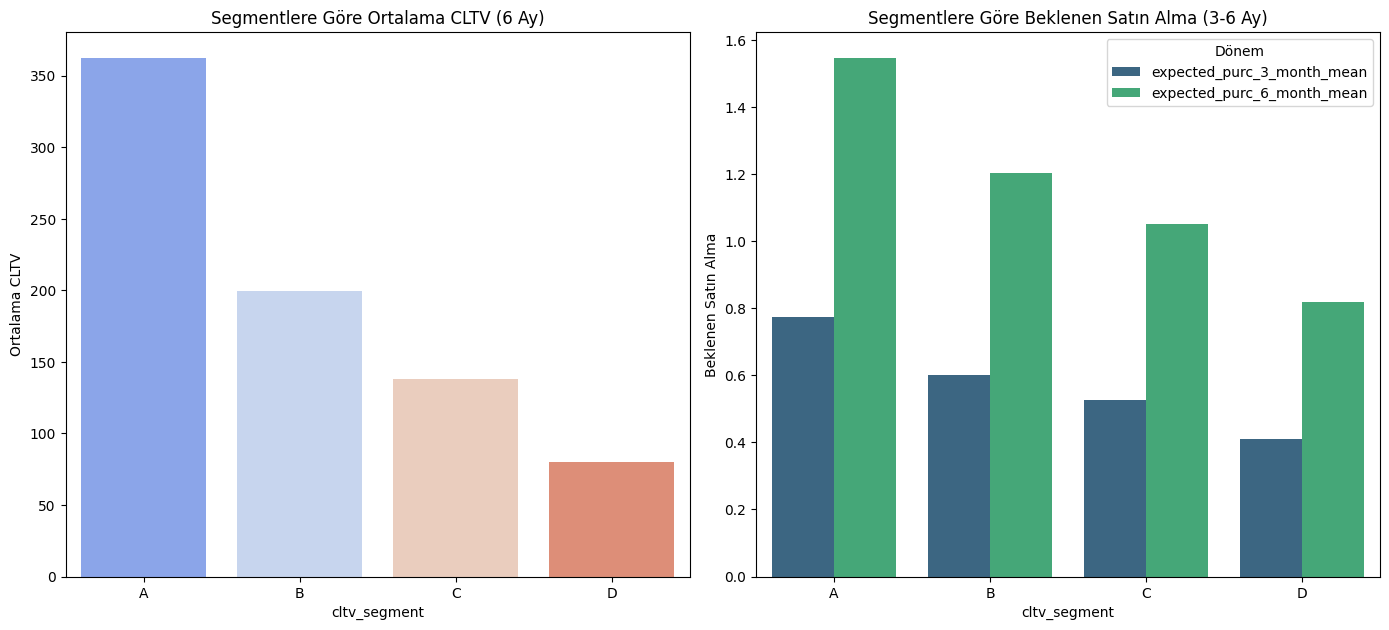

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Örnek veri (CLTV segment bazında özet istatistikler)
data = {
    "cltv_segment": ["A", "B", "C", "D"],
    "cltv_6_month_mean": [362.315, 199.533, 138.312, 80.340],
    "expected_purc_3_month_mean": [0.773, 0.601, 0.525, 0.409],
    "expected_purc_6_month_mean": [1.546, 1.202, 1.051, 0.818],
    "expected_average_profit_mean": [238.024, 168.001, 132.251, 98.691],
    "recency_cltv_weekly_mean": [67.427, 81.988, 92.630, 139.000],
    "frequency_mean": [6.647, 5.093, 4.405, 3.769]
}

df = pd.DataFrame(data)

# Segmentleri belirli sıraya göre sıralama
df["cltv_segment"] = pd.Categorical(df["cltv_segment"], categories=["A", "B", "C", "D"], ordered=True)
df = df.sort_values("cltv_segment")

# Grafiklerin boyutunu ayarla
plt.figure(figsize=(14, 12))

# 1. Segmentlere Göre Ortalama CLTV Dağılımı
plt.subplot(2, 2, 1)
sns.barplot(x=df["cltv_segment"], y=df["cltv_6_month_mean"], palette="coolwarm")
plt.title("Segmentlere Göre Ortalama CLTV (6 Ay)")
plt.ylabel("Ortalama CLTV")

# 2. Segmentlere Göre Beklenen Satın Alma Sayısı (3 ve 6 ay)
plt.subplot(2, 2, 2)
df_melted = df.melt(id_vars=["cltv_segment"], value_vars=["expected_purc_3_month_mean", "expected_purc_6_month_mean"], 
                     var_name="Dönem", value_name="Beklenen Satın Alma")
sns.barplot(x=df_melted["cltv_segment"], y=df_melted["Beklenen Satın Alma"], hue=df_melted["Dönem"], palette="viridis")
plt.title("Segmentlere Göre Beklenen Satın Alma (3-6 Ay)")
plt.ylabel("Beklenen Satın Alma")


plt.tight_layout()
plt.show()



In [31]:
CLTV.groupby("cltv_segment").agg({"customer_id": "count"})

,customer_id
cltv_segment,
D,4987
C,4986
B,4986
A,4986


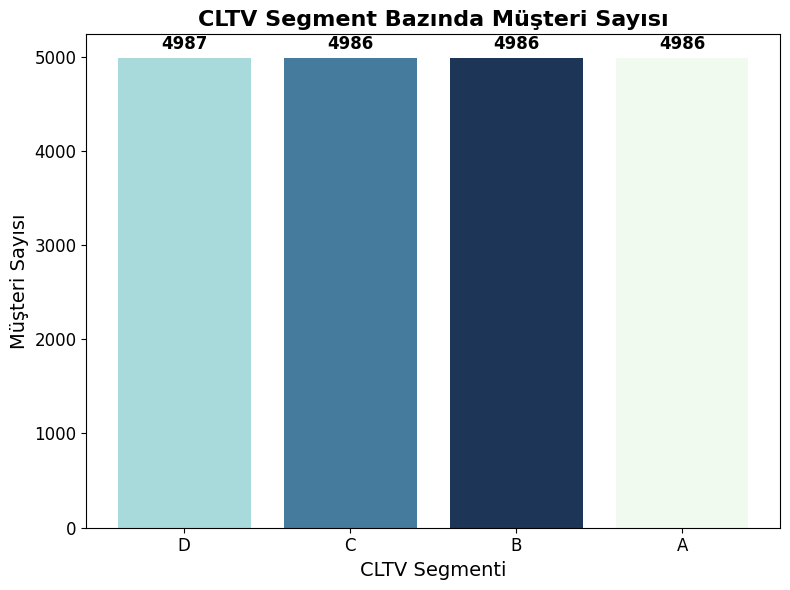

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Örnek veriyi simüle ediyorum
data = {'cltv_segment': ['D', 'C', 'B', 'A'],
        'customer_id': [4987, 4986, 4986, 4986]}

df = pd.DataFrame(data)

# Sofistike renkler tanımlanır (pastel tonları)
colors = ['#A8DADC', '#457B9D', '#1D3557', '#F1FAEE']

# Grafik oluşturma
plt.figure(figsize=(8, 6))
bars = plt.bar(df['cltv_segment'], df['customer_id'], color=colors)

# Başlık ve etiketler
plt.title('CLTV Segment Bazında Müşteri Sayısı', fontsize=16, fontweight='bold')
plt.xlabel('CLTV Segmenti', fontsize=14)
plt.ylabel('Müşteri Sayısı', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Her çubuğun üstüne müşteri sayısını ekleme
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50,  # Konum ayarı
             int(yval), ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Grafik gösterimi
plt.tight_layout()
plt.show()

D Group (Lowest CLTV):

CLTV value is 80.34, which is low.
This group buys less frequently and provides less profit.
Strategy: Loyalty-building campaigns can be created for this group. The goal could be to encourage them to shop more often. Additionally, offering personalized deals through recommendation systems could help increase their shopping frequency.

C Group:

CLTV value is 138.31, which is higher but still low.
They shop at a moderate level and provide moderate profit.
Strategy: Customers in this group already have a certain shopping pattern. Cross-selling or upselling strategies (suggesting more expensive products) could be applied. VIP programs and special discounts could also be offered to build customer loyalty.

B Group:

CLTV value is 199.53, which is quite high.
This group shops more often and provides more profit.
Strategy: This group consists of active and profitable customers. The goal is to retain them. More personalized offers and VIP customer deals could be given. Additionally, special campaigns and events could be organized for them.

A Group (Highest CLTV):

CLTV value is 362.31, the highest.
This group shops the most frequently and provides the highest profit.
Strategy: For this group, the highest level of personalized offers, loyalty programs, and special campaigns introducing new products can be applied. This group should be the main focus in customer relationship management, as losing them would lead to significant revenue loss.

Gamma Method Result:

The Gamma method is used to understand the predicted profit over the customer's lifetime and works similarly to CLTV analysis. A high CLTV indicates a high customer lifetime value, meaning these customers are expected to be more profitable. Customers with a high gamma value are considered more valuable for generating higher revenue.

Based on this data, strategies for the A and B groups may need to be more aggressive, as these groups shop more often and provide higher profits, showing great potential. For the C and D groups, more incentives and loyalty-building strategies may be necessary.

In conclusion, strategies should be tailored based on the potential and current shopping behavior of each group.